In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
import random
# import sktime

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from redshift import get_from_redshift
from datetime import datetime
from config import Config  
from collections import defaultdict, Counter
from tqdm import tqdm 
from itertools import zip_longest

tqdm.pandas()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Loading data

In [2]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_work_experience) 

In [3]:
candidate_work_experience = get_from_redshift(sql_path, Config.redshift_creds)
candidate_work_experience.head()

,candidate_id,unique_id,date_start_job,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source
0,96481,2192150,2000-08-14 00:00:00,2000-08-14,2038.0,1.0,9329.0,Functienaam van code 9970,Banta Global Turnkey B.V.,plaatsing
1,96481,215214,2000-08-16 00:00:00,2000-09-18,2038.0,1.0,9329.0,Functienaam van code 9970,Kamp Coating Apeldoorn BV,plaatsing
2,96481,246438,2004-08-16 00:00:00,2004-08-23,2038.0,1.0,9329.0,Productie-medew uitz,Coldec Productie B.V.,plaatsing
3,96481,2182290,2004-09-13 00:00:00,2005-03-31,2439.0,1.0,9321.0,None,Banta Global Turnkey B.V.,plaatsing
4,96481,2428432,2005-11-18 00:00:00,2006-05-08,2038.0,1.0,9329.0,None,Banta Global Turnkey B.V.,plaatsing


In [4]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_education) 

In [5]:
candidate_education = get_from_redshift(sql_path, Config.redshift_creds)
candidate_education.head()

,candidate_id,education_level,date_start,date_end,date_registrated,passed
0,181264,2,1993-09-01 00:00:00,1994-06-30 00:00:00,2005-08-09 18:37:24,0
1,286976,3,1996-09-01 00:00:00,1999-09-01 00:00:00,2005-08-16 19:15:22,1
2,387100,3,1991-09-01 00:00:00,1997-06-01 00:00:00,2005-08-30 11:42:21,1
3,181264,3,1994-08-01 00:00:00,1996-07-31 00:00:00,2005-08-09 18:37:24,0
4,389441,2,1988-09-01 00:00:00,1990-06-01 00:00:00,2005-08-30 11:49:34,1


In [6]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_skills) 

#### What's date start here? 

In [7]:
candidate_skill = get_from_redshift(sql_path, Config.redshift_creds)
candidate_skill.head()

,candidate_id,skill_id,date_start
0,2093266,2991,2015-06-02 13:04:00
1,3427159,62,2015-09-02 14:14:20
2,5718216,62,2016-07-26 23:22:12
3,6571130,14,2016-03-29 15:04:37
4,5448003,934,2016-03-03 17:08:39


# Skill reindexing

In [8]:
skill_to_idx = {v : i for i, v in enumerate(sorted(candidate_skill["skill_id"].astype(float).unique()))}
idx_to_skill = {i : v for i, v in skill_to_idx.items()}
candidate_skill["skill_id"] = candidate_skill["skill_id"].replace(skill_to_idx)
skills_dict = candidate_skill.groupby("candidate_id")["skill_id"].apply(list).to_dict()

In [9]:
# TODO: do this in a way that doesn't require 70gb of memory lol
# Convert lists of skills to dataframe of skills per candidate
skills_ct = pd.crosstab(candidate_skill["candidate_id"], 
                        candidate_skill["skill_id"])

# skills = skills_ct.where(skills_ct != 1, skills_ct.columns.to_series(), axis=1)
skills_ct.columns = [f"skill_{i}" for i in skills_ct.columns]

# Merging and formatting

In [10]:
def clean_df(df, table = "work_experience"):
    
    if table == "work_experience":
        start, end = "date_start_job", "date_end_job"
    elif table == "education":
        start, end = "date_start", "date_end"
    else:
        return NotImplemented
    
    # Drop nonsense data
    df = df[df[start] >= dt.datetime(1800, 1, 1)]
    df = df[df[end] <= dt.datetime(2100, 1, 1)]

    # Convert datetime to date
    df[start] = pd.to_datetime(df[start]).dt.date
    df[end] = pd.to_datetime(df[end]).dt.date
    
    return df
        
candidate_work_experience = clean_df(candidate_work_experience)
candidate_education = clean_df(candidate_education, table = "education")

In [11]:
candidate_work_experience["time_spent"] = (candidate_work_experience["date_end_job"] - 
                                           candidate_work_experience["date_start_job"]).dt.days.astype('int16')

In [12]:
def find_educations(df_work, df_education):

    # Merge career data with education levels
    career_education = pd.merge(df_work, 
                                df_education, 
                                on = "candidate_id", 
                                how = "left")[["candidate_id",
                                               "date_start_job",
                                               "date_end_job",
                                               "time_spent",
                                               "education_level",
                                               "date_start",
                                               "date_end",
                                               "passed"]]
    
    # Filter out education that were not passed (yet) at the time of starting a job
    passed = career_education[(career_education["date_start_job"] >= career_education["date_end"]) & 
                              (career_education["passed"] == 1)]
    
    # Only store the highest education level reached at the start of each job
    education_through_time = passed.groupby(["candidate_id", "date_start_job"])["education_level"].max()
    
    df_work.set_index(["candidate_id", "date_start_job"], inplace=True)

    # Store education data in candidate_work_experience
    df_work["education"] = education_through_time

    # np.nan education = no education
    df_work["education"].fillna(0, inplace=True)

    # Reset index for further data augmentation
    df_work.reset_index(inplace=True)
        
    return df_work

candidate_work_experience = find_educations(candidate_work_experience, candidate_education)

candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,time_spent,education
0,96481,2000-08-14,2192150,2000-08-14,2038.0,1.0,9329.0,Functienaam van code 9970,Banta Global Turnkey B.V.,plaatsing,0,0.0
1,96481,2000-08-16,215214,2000-09-18,2038.0,1.0,9329.0,Functienaam van code 9970,Kamp Coating Apeldoorn BV,plaatsing,33,0.0
2,96481,2004-08-16,246438,2004-08-23,2038.0,1.0,9329.0,Productie-medew uitz,Coldec Productie B.V.,plaatsing,7,3.0
3,96481,2004-09-13,2182290,2005-03-31,2439.0,1.0,9321.0,None,Banta Global Turnkey B.V.,plaatsing,199,3.0
4,96481,2005-11-18,2428432,2006-05-08,2038.0,1.0,9329.0,None,Banta Global Turnkey B.V.,plaatsing,171,3.0


In [13]:
# Add skills
candidate_work_experience = pd.merge(candidate_work_experience, 
                                     skills_ct, 
                                     left_on="candidate_id", 
                                     right_index=True, 
                                     how="left")

# Filtering and reindexing

In [14]:
more_than_5 = candidate_work_experience["isco_code4"].value_counts()
more_than_5 = set(more_than_5[more_than_5 > 5].index)
candidate_work_experience = candidate_work_experience[candidate_work_experience["isco_code4"].isin(more_than_5)]

In [15]:
id_to_idx = {v : i for i, v in enumerate(sorted(candidate_work_experience["function_id"].astype(float).unique()))}
idx_to_id = {i : v for i, v in id_to_idx.items()}

code_to_idx = {v : i for i, v in enumerate(sorted(candidate_work_experience["isco_code4"].astype(float).unique()))}
idx_to_code = {i : v for i, v in code_to_idx.items()}

In [16]:
candidate_work_experience["function_id"] = candidate_work_experience["function_id"].replace(id_to_idx)
candidate_work_experience["isco_code4"] = candidate_work_experience["isco_code4"].replace(code_to_idx)

In [17]:
candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,...,skill_307,skill_308,skill_309,skill_310,skill_311,skill_312,skill_313,skill_314,skill_315,skill_316
0,96481,2000-08-14,2192150,2000-08-14,1523.0,1.0,343.0,Functienaam van code 9970,Banta Global Turnkey B.V.,plaatsing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96481,2000-08-16,215214,2000-09-18,1523.0,1.0,343.0,Functienaam van code 9970,Kamp Coating Apeldoorn BV,plaatsing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96481,2004-08-16,246438,2004-08-23,1523.0,1.0,343.0,Productie-medew uitz,Coldec Productie B.V.,plaatsing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96481,2004-09-13,2182290,2005-03-31,1840.0,1.0,342.0,None,Banta Global Turnkey B.V.,plaatsing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,96481,2005-11-18,2428432,2006-05-08,1523.0,1.0,343.0,None,Banta Global Turnkey B.V.,plaatsing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Ordering & Time

In [18]:
# Calculate the time it took to go from one job to another (in order)
candidate_work_experience["time_between"] = candidate_work_experience.groupby(
    "candidate_id")["date_start_job"].progress_apply(lambda x: x - x.shift(1))

100%|██████████| 467453/467453 [05:08<00:00, 1514.11it/s]


In [19]:
def add_order(df):
    
    # Count the number of jobs each candidate has ahd
    job_counts = df.groupby("candidate_id").size()  
    
    # Sort by candidate_id, date_start_job
    sorted_df = df.sort_values(by = ['candidate_id', "date_start_job"])
    
    # Reset index
    sorted_df.reset_index(inplace=True, drop=True)
    
    
    # Create a list of lists containing the order of each candidates jobs (which came first, second, third, etc.)
    order = [np.arange(count) for count in job_counts.values]
    
    # Flatten list
    order = [item for sublist in order for item in sublist]
    
    # Add order to df
    sorted_df["job_order"] = order
    
    # Set a candidate_id, job_order as the index
    return sorted_df.set_index(["candidate_id", 
                                "job_order"])

df = add_order(candidate_work_experience)

In [20]:
df = df[["date_start_job", "date_end_job", "time_spent", "time_between", "isco_code4", "function_id",
         "isco_functie_niveau", "company_name", "source", "education"] + [col for col in df.columns if "skill_" in col]]

df["time_between"] = df["time_between"].shift(-1).fillna(pd.Timedelta(seconds=0)).dt.days.astype('int16')
df.head()

date_start_job date_end_job  time_spent  time_between  \
candidate_id job_order                                                         
84556        0             2000-08-01   2001-01-04         156            37   
             1             2000-09-07   2001-01-01         116            23   
             2             2000-09-30   2001-07-02         275            23   
             3             2000-10-23   2000-10-27           4          1155   
             4             2003-12-22   2004-01-02          11           203   

                        isco_code4  function_id  isco_functie_niveau  \
candidate_id job_order                                                 
84556        0               207.0        939.0                  2.0   
             1               347.0        813.0                  1.0   
             2               207.0        939.0                  2.0   
             3               343.0       1523.0                  1.0   
             4               343.0       1523.0                  1.0   

                                                    company_name     source  \
candidate_id job_order                                                        
84556        0          (oud 3146Amsterdam RAI Catering Services  plaatsing   
             1          (oud 3146Amsterdam RAI Catering Services  plaatsing   
             2              AMSTERDAM RAI CATERING SERVICES B.V.  plaatsing   
             3                                 Formido Bouwmarkt  plaatsing   
             4                             Yakult Nederland B.V.  plaatsing   

                        education  ...  skill_307  skill_308  skill_309  \
candidate_id job_order             ...                                    
84556        0                0.0  ...        0.0        0.0        0.0   
             1                0.0  ...        0.0        0.0        0.0   
             2                0.0  ...        0.0        0.0        0.0   
             3                0.0  ...        0.0        0.0        0.0   
             4                0.0  ...        0.0        0.0        0.0   

                        skill_310  skill_311  skill_312  skill_313  skill_314  \
candidate_id job_order                                                          
84556        0                0.0        0.0        0.0        0.0        0.0   
             1                0.0        0.0        0.0        0.0        0.0   
             2                0.0        0.0        0.0        0.0        0.0   
             3                0.0        0.0        0.0        0.0        0.0   
             4                0.0        0.0        0.0        0.0        0.0   

                        skill_315  skill_316  
candidate_id job_order                        
84556        0                0.0        0.0  
             1                0.0        0.0  
             2                0.0        0.0  
             3                0.0        0.0  
             4                0.0        0.0  

[5 rows x 327 columns]

In [21]:
num_classes = len(df["isco_code4"].unique())

In [44]:
def naive_predictor(df):    
    grouped = df.groupby(level=0).apply(lambda x: x.values)
    grouped = grouped.loc[grouped.apply(len) > 1]
    return np.mean(grouped.apply(lambda x: x[-1] == x[-2])) * 100
    
naive_predictor(df["isco_code4"])

57.2973074397223

# Some graphs

In [35]:
dist = df["isco_code4"].value_counts().sort_values(ascending=False).reset_index(drop=True)
dist2 = df["function_id"].value_counts().sort_values(ascending=False).reset_index(drop=True)
dist_ed = df["education"].value_counts().sort_values(ascending=False).reset_index(drop=True)

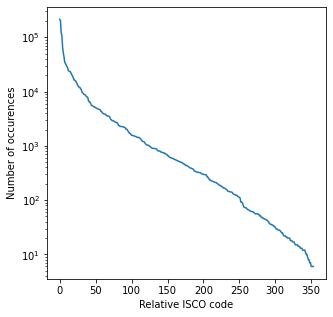

In [36]:
plt.figure(figsize = (5, 5))
plt.xlabel("Relative ISCO code")
plt.ylabel("Number of occurences")
plt.yscale("log")
plt.plot(dist.index, dist.values)

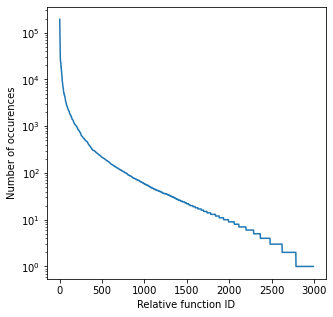

In [37]:
plt.figure(figsize = (5, 5))
plt.xlabel("Relative function ID")
plt.ylabel("Number of occurences")
plt.yscale("log")
plt.plot(dist2.index, dist2.values)

<BarContainer object of 6 artists>

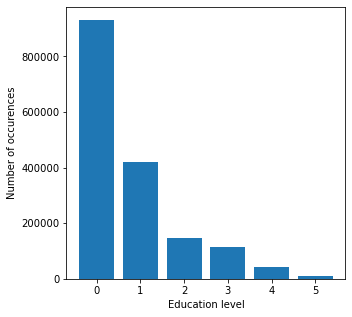

In [38]:
plt.figure(figsize = (5, 5))
plt.xlabel("Education level")
plt.ylabel("Number of occurences")
# plt.yscale("log")
plt.bar(dist_ed.index, dist_ed.values)

In [39]:
# df_pred = df[["isco_functie_niveau", "education", "function_id"]].fillna(0)
pred_cols = ["time_between", "time_spent", "isco_functie_niveau", 
             "education", "function_id", "isco_code4"] + [col for col in df.columns if "skill_" in col]
num_features = len(pred_cols)

df_pred = df[pred_cols].fillna(0)

In [40]:
df_pred.head()

time_between  time_spent  isco_functie_niveau  \
candidate_id job_order                                                  
84556        0                    37         156                  2.0   
             1                    23         116                  1.0   
             2                    23         275                  2.0   
             3                  1155           4                  1.0   
             4                   203          11                  1.0   

                        education  function_id  isco_code4  skill_0  skill_1  \
candidate_id job_order                                                         
84556        0                0.0        939.0       207.0      0.0      0.0   
             1                0.0        813.0       347.0      0.0      0.0   
             2                0.0        939.0       207.0      0.0      0.0   
             3                0.0       1524.0       343.0      0.0      0.0   
             4                0.0       1524.0       343.0      0.0      0.0   

                        skill_2  skill_3  ...  skill_307  skill_308  \
candidate_id job_order                    ...                         
84556        0              0.0      0.0  ...        0.0        0.0   
             1              0.0      0.0  ...        0.0        0.0   
             2              0.0      0.0  ...        0.0        0.0   
             3              0.0      0.0  ...        0.0        0.0   
             4              0.0      0.0  ...        0.0        0.0   

                        skill_309  skill_310  skill_311  skill_312  skill_313  \
candidate_id job_order                                                          
84556        0                0.0        0.0        0.0        0.0        0.0   
             1                0.0        0.0        0.0        0.0        0.0   
             2                0.0        0.0        0.0        0.0        0.0   
             3                0.0        0.0        0.0        0.0        0.0   
             4                0.0        0.0        0.0        0.0        0.0   

                        skill_314  skill_315  skill_316  
candidate_id job_order                                   
84556        0                0.0        0.0        0.0  
             1                0.0        0.0        0.0  
             2                0.0        0.0        0.0  
             3                0.0        0.0        0.0  
             4                0.0        0.0        0.0  

[5 rows x 323 columns]

In [41]:
career_paths = df_pred.groupby(level = 0)

In [42]:
# TODO: speed this up 
career_paths = career_paths.progress_apply(lambda x: x.values)

100%|██████████| 466467/466467 [01:58<00:00, 3929.56it/s]


In [43]:
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens < 150) & (career_lens > 1)]

In [44]:
career_paths.head()

candidate_id
84556    [[37.0, 156.0, 2.0, 0.0, 939.0, 207.0, 0.0, 0....
84612    [[2537.0, 6.0, 1.0, 0.0, 1524.0, 343.0, 0.0, 0...
84731    [[46.0, 23.0, 1.0, 0.0, 1524.0, 343.0, 0.0, 0....
85437    [[747.0, 670.0, 1.0, 2.0, 1524.0, 343.0, 0.0, ...
85627    [[140.0, 4627.0, 3.0, 0.0, 1925.0, 155.0, 0.0,...
dtype: object

<BarContainer object of 145 artists>

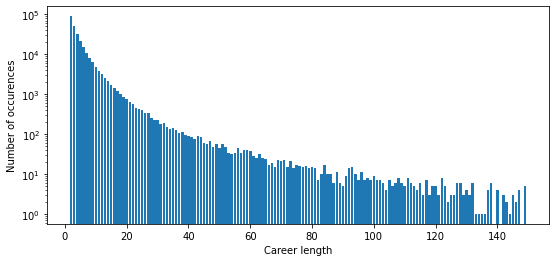

In [45]:
seq_len_dist = career_paths.apply(len).value_counts().sort_values(ascending=False)

plt.figure(figsize = (9, 4))
plt.xlabel("Career length")
plt.ylabel("Number of occurences")
plt.yscale("log")
plt.bar(seq_len_dist.index, seq_len_dist.values)

In [46]:
# max_skills = len(max([v for _, v in skills_dict.items()], key=len))

# for idx, career in zip(career_paths.index, career_paths.values):
#     current_skills = skills_dict[idx]
#     current_skills.extend([0] * (max_skills - len(current_skills)))
    
#     time_series = career[:-1].reshape(len(career) - 1, num_features)
    
#     skills_series = np.stack([current_skills] * time_series.shape[0])
    
#     full = np.hstack((time_series, skills_series))

In [52]:
# Some dummy time series
x = []
y = []

max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, 6]

    time_series = career[:-1].reshape(len(career) - 1, num_features + max_skills)

#     if idx in skills_dict:
#         current_skills = skills_dict[idx]
#         current_skills.extend([0] * (max_skills - len(current_skills)))
#         skills_series = np.stack([current_skills] * time_series.shape[0])
#     else:
#         skills_series = np.zeros((time_series.shape[0], max_skills))

#     full = np.hstack((time_series, skills_series))

    if not np.isnan(label):
        # Change back to full and num_features + max_skills if needed
        x.append(time_series[:-1].reshape(len(time_series) - 1, num_features))
        y.append(label)
    #       counts[label] += 1
    
x = np.array(x)
y = np.array(y)

NameError: name 'df_pred' is not defined

In [50]:
del df
del df_pred
del career_paths
del seq_len_dist
del candidate_work_experience
del candidate_skill
del candidate_education
del more_than_5
del dist
del dist2
del dist_ed

In [51]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

MemoryError: Unable to allocate array with shape (266272, 147, 323) and data type float64

In [63]:
to_fill.shape

(266272, 147, 8)

In [64]:
# del x

# PyTorch

In [65]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [66]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

In [67]:
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [68]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((213017, 147, 8), (53255, 147, 8), (213017,), (53255,))

In [70]:
# classes = df_pred["isco_code4"].value_counts()
# labels = df_pred["isco_code4"].values.astype(int)

counts = np.bincount(y_train) + 1
labels_weights = 1. / counts
weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

In [71]:
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).type(torch.LongTensor))
trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val).type(torch.LongTensor))
valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [72]:
len(trainloader), len(valloader)

(417, 105)

In [89]:
# for i, _ in trainloader:
#     candidates = i[:, -1, 0]
#     [np.lib.pad(skill_dict[i.item()],  for i in candidates if i.item() in skill_dict]

                

In [61]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, embedding_size):
        super(LSTM, self).__init__()
              
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.LSTMs = nn.ModuleList()
        
        for i in range(num_layers):
            input_size = input_size if i == 0 else hidden_size
            self.LSTMs.append(nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                      num_layers=1, batch_first=True))
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.embedding = nn.Embedding(316, embedding_size)
        # self.conv = nn.Conv1d(613, 3, 1)

    def forward(self, x):
        outputs = []       
        
        for i in range(self.num_layers):
            output, (h_n, c_n) = self.LSTMs[i](x)
            outputs.append(output)
            x = output

        h_out = h_n.view(-1, self.hidden_size)
        out = self.fc(h_out)
                        
        return out

In [51]:
def train_loop(model, trainloader, valloader, optimizer, criterion, num_epochs):

    # Train the model
    for epoch in range(num_epochs):
        for i, (career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs = model(career)

            # obtain the loss function
            loss = criterion(outputs, job)
            
            loss = loss.mean()
            
            loss.backward()

            optimizer.step()
#             if i % 100 == 0:
#                 print(outputs.argmax(1), job)
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i, len(trainloader), loss.item()), end="\r")
        
#        print("\nTraining:", Counter(np.array(outputs.argmax(1).cpu())))
        test_loop(valloader, model, criterion)
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred = model(career)      
            test_loss += criterion(pred, job).mean().item()
            correct += (pred.argmax(1) == job).type(torch.float).sum().item()
            
    print("\nValidation:", Counter(np.array(pred.argmax(1).cpu())))
        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}\n")
    return (100 * correct), test_loss

In [62]:
# weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                             classes = classes.index,
#                                             y = df_pred["isco_code4"].values)

# weights = torch.Tensor(weights).to(device)

num_epochs = 5

current = 0

# weight = weights, reduction="none"
criterion = torch.nn.CrossEntropyLoss()
            
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

for learning_rate in [1e-1, 1e-2, 1e-3, 1e-4][1:]:
    for num_layers in [1, 3, 5, 10][2:]:
        for hidden_size in [1, 3, 5, 10][2:]:

            lstm = LSTM(num_classes=num_classes,
                        input_size=num_features,
                        num_layers=num_layers,
                        hidden_size=hidden_size,
                        embedding_size=5)

            lstm = lstm.to(device)
            
            optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

            
            print(f"Current iteration {current}/{4**3}\n- Learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

            train_loop(lstm, trainloader, valloader, optimizer, criterion, num_epochs)
            
            current += 1
            
            break
        break
    break

Current iteration 0/64
- Learning rate: 0.01
- Model: 

 LSTM(
  (LSTMs): ModuleList(
    (0): LSTM(6, 5, batch_first=True)
    (1): LSTM(5, 5, batch_first=True)
    (2): LSTM(5, 5, batch_first=True)
    (3): LSTM(5, 5, batch_first=True)
    (4): LSTM(5, 5, batch_first=True)
  )
  (fc): Linear(in_features=5, out_features=367, bias=True)
  (embedding): Embedding(316, 5)
) 

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.00

NameError: name 'ashdjkasd' is not defined

### Might be useful later on

In [ ]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_certificates) 

candidate_certificates = get_from_redshift(sql_path, Config.redshift_creds)

In [ ]:
candidate_certificates.groupby("candidate_id")["candidate_certificate_id"].apply(list)

In [ ]:
candidate_certificates.info(null_counts=True)

In [ ]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_skills_mapping) 

skill_mappings = get_from_redshift(sql_path, Config.redshift_creds)

In [ ]:
candidate_skill.head()

In [ ]:
candidate_skill.info(null_counts=True)

In [ ]:
skill_mappings.head()